In [18]:
import pandas as pd
import numpy as np
#import utils
import io
import itertools
import matplotlib.pyplot as plt
import time
import math
import unidecode
import requests
import seaborn as sns
from sklearn.linear_model import LinearRegression
from scipy import stats
from scipy.stats import norm, skew, pearsonr #for some statistics
from sklearn.metrics import mean_squared_error
from sklearn import datasets, ensemble
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

from bs4 import BeautifulSoup
import re
import sys, getopt
import csv
from collections import Counter
pd.set_option('display.max_columns', None)

pd.options.display.max_columns=999

import warnings
warnings.filterwarnings('ignore')

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

## XGBoost for Shot Projection - MLS Data

In [20]:
mls_data = pd.read_csv("Shotlogs/MLS_shotlog.csv")
futures = mls_data[mls_data["Real_Shots"].isna()]
futures = futures[futures["Win_Odds"].notna()]
mls_data = mls_data[mls_data["Real_Shots"] > 0]

## Outliers w/ numbers
#iqr = stats.iqr(mls_data["Real_SoT"])
#outlier_cutoff_low = np.quantile(np.array(mls_data["Real_SoT"]),.25) - iqr*1.5
#outlier_cutoff_high = np.quantile(np.array(mls_data["Real_SoT"]),.75) + iqr*1.5
#num_outliers = sum(mls_data["Real_SoT"] > outlier_cutoff_high)
#print("num outliers:", num_outliers)
#outlier_indices = []
#for i in range(num_outliers):
#    idx = mls_data["Real_SoT"].drop(outlier_indices).idxmax()
#    outlier_indices.append(idx)
#mls_data = mls_data.drop(outlier_indices).reset_index()

# Set X and y matrices for linear regression
X = np.array(mls_data[["Win_Odds", "FiveThirtyEight_Odds",
                       "Odds_GF", "OddsShark_GF",
                       "Opp_CS_Odds_INV", "Opp_Odds_INV", "Opp_FiveThirtyEight_Odds_INV"]])
y = np.array(mls_data["Real_Shots"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)
params = {'n_estimators': 500,
          'max_depth': 4,
          'min_samples_split': 5,
          'learning_rate': 0.01,
          'loss': 'ls'}

reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(X_train, y_train)

mse = mean_squared_error(y_test, reg.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

The mean squared error (MSE) on test set: 22.0651


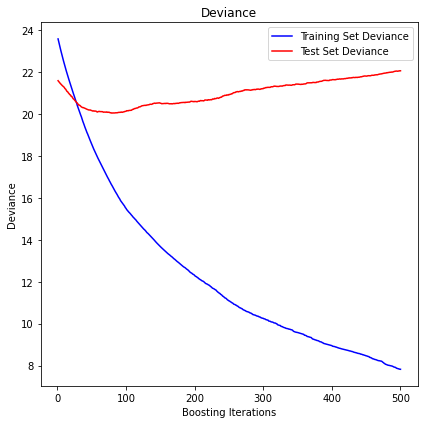

In [21]:
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)
for i, y_pred in enumerate(reg.staged_predict(X_test)):
    test_score[i] = reg.loss_(y_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, reg.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')
fig.tight_layout()
plt.show()

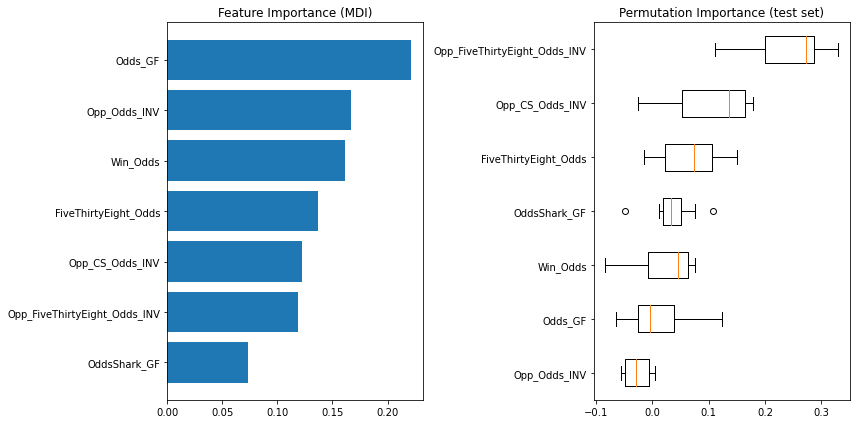

In [22]:
feature_importance = reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(["Win_Odds", "FiveThirtyEight_Odds",
                           "Odds_GF", "OddsShark_GF",
                           "Opp_CS_Odds_INV", "Opp_Odds_INV", "Opp_FiveThirtyEight_Odds_INV"])[sorted_idx])
plt.title('Feature Importance (MDI)')

result = permutation_importance(reg, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(result.importances[sorted_idx].T,
            vert=False, labels=np.array(["Win_Odds", "FiveThirtyEight_Odds",
                                           "Odds_GF", "OddsShark_GF",
                                           "Opp_CS_Odds_INV", "Opp_Odds_INV", "Opp_FiveThirtyEight_Odds_INV"])[sorted_idx])
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

### XGBoost vs Linear Reg for Shots by League

In [24]:
## Run this cell to get the shot and SoT projections
## Fill in the league to get the write patch to the shotlog file
#################################################################################################################

leagues = ["MLS", "PremierLeague", "Bundesliga", "Ligue1", "SerieA", "LaLiga"]  # MLS, PremierLeague, Bundesliga, LaLiga, Ligue1, SerieA

#################################################################################################################
for league in leagues:
    print("\n")
    print(league)
    filename = "Shotlogs/" + league + "_shotlog.csv"
    
    # Named for MLS shot projections, but works for any league
    mls_data = pd.read_csv(filename)
    futures = mls_data[mls_data["Real_Shots"].isna()]
    futures = futures[futures["Win_Odds"].notna()]
    mls_data = mls_data[mls_data["Real_Shots"] > 0]

    # Outliers w/ numbers
    iqr = stats.iqr(mls_data["Real_Shots"])
    outlier_cutoff_low = np.quantile(np.array(mls_data["Real_Shots"]),.25) - iqr*1.5
    outlier_cutoff_high = np.quantile(np.array(mls_data["Real_Shots"]),.75) + iqr*1.5
    num_outliers = sum(mls_data["Real_Shots"] > outlier_cutoff_high)
    print("num outliers:", num_outliers)
    outlier_indices = []
    for i in range(num_outliers):
        idx = mls_data["Real_Shots"].drop(outlier_indices).idxmax()
        outlier_indices.append(idx)
    mls_data = mls_data.drop(outlier_indices).reset_index()

    # Set X and y matrices for linear regression
    X = np.array(mls_data[["Win_Odds", "FiveThirtyEight_Odds",
                           "Odds_GF", "OddsShark_GF",
                           "Opp_CS_Odds_INV", "Opp_Odds_INV", "Opp_FiveThirtyEight_Odds_INV"]])
    y = np.array(mls_data["Real_Shots"])
    linear_regression = LinearRegression(normalize=True)
    linear_regression.fit(X, y)
    y_pred = linear_regression.predict(X)
    mse = mean_squared_error(y, y_pred)
    print("Shot Regression MSE: {:.4f}".format(mse))
    
    params = {'n_estimators': 500,
          'max_depth': 4,
          'min_samples_split': 5,
          'learning_rate': 0.01,
          'loss': 'ls'}
    reg = ensemble.GradientBoostingRegressor(**params)
    reg.fit(X, y)
    mse = mean_squared_error(y, reg.predict(X))
    print("Shot XGBoost MSE:    {:.4f}".format(mse))
    
# XGBoost performs well without a train-test split, suggesting overfitting here



MLS
num outliers: 5
Shot Regression MSE: 17.4084
Shot XGBoost MSE:    8.2633


PremierLeague
num outliers: 2
Shot Regression MSE: 20.1001
Shot XGBoost MSE:    3.8307


Bundesliga
num outliers: 1
Shot Regression MSE: 13.6113
Shot XGBoost MSE:    1.8360


Ligue1
num outliers: 1
Shot Regression MSE: 20.6977
Shot XGBoost MSE:    2.0578


SerieA
num outliers: 1
Shot Regression MSE: 21.5103
Shot XGBoost MSE:    3.1853


LaLiga
num outliers: 1
Shot Regression MSE: 11.2968
Shot XGBoost MSE:    1.1319


Text(0.5, 0, 'Real Values')

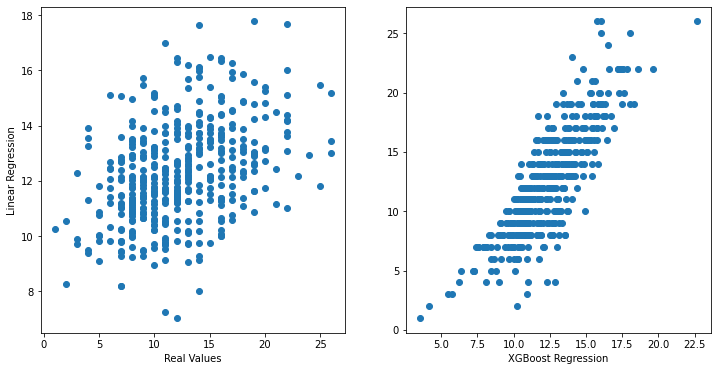

In [25]:
# Plot the predictions for MLS to visualize the MSE we found

mls_data = pd.read_csv("Shotlogs/MLS_shotlog.csv")
futures = mls_data[mls_data["Real_Shots"].isna()]
futures = futures[futures["Win_Odds"].notna()]
mls_data = mls_data[mls_data["Real_Shots"] > 0]

# Outliers w/ numbers
iqr = stats.iqr(mls_data["Real_Shots"])
outlier_cutoff_low = np.quantile(np.array(mls_data["Real_Shots"]),.25) - iqr*1.5
outlier_cutoff_high = np.quantile(np.array(mls_data["Real_Shots"]),.75) + iqr*1.5
num_outliers = sum(mls_data["Real_Shots"] > outlier_cutoff_high)
#print("num outliers:", num_outliers)
outlier_indices = []
for i in range(num_outliers):
    idx = mls_data["Real_Shots"].drop(outlier_indices).idxmax()
    outlier_indices.append(idx)
mls_data = mls_data.drop(outlier_indices).reset_index()

# Set X and y matrices for linear regression
X = np.array(mls_data[["Win_Odds", "FiveThirtyEight_Odds",
                       "Odds_GF", "OddsShark_GF",
                       "Opp_CS_Odds_INV", "Opp_Odds_INV", "Opp_FiveThirtyEight_Odds_INV"]])
y = np.array(mls_data["Real_Shots"])
linear_regression = LinearRegression(normalize=True)
linear_regression.fit(X, y)
y_pred = linear_regression.predict(X)
mse = mean_squared_error(y, y_pred)
#print("Shot Regression MSE: {:.4f}".format(mse))

params = {'n_estimators': 500,
      'max_depth': 4,
      'min_samples_split': 5,
      'learning_rate': 0.01,
      'loss': 'ls'}
reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(X, y)
mse = mean_squared_error(y, reg.predict(X))
#print("Shot XGBoost MSE:    {:.4f}".format(mse))


fig, ax = plt.subplots(1,2, figsize=(12,6))
ax[0].scatter(y, y_pred)
ax[0].set_ylabel("Linear Regression")
ax[0].set_xlabel("Real Values")
ax[1].scatter(reg.predict(X), y)
ax[1].set_xlabel("XGBoost Regression")
ax[0].set_xlabel("Real Values")

In [26]:
## Run this cell to get the shot and SoT projections with a train-test split
## Fill in the league to get the write patch to the shotlog file
#################################################################################################################

leagues = ["MLS", "PremierLeague", "Bundesliga", "Ligue1", "SerieA", "LaLiga"]  # MLS, PremierLeague, Bundesliga, LaLiga, Ligue1, SerieA

#################################################################################################################
for league in leagues:
    print("\n")
    print(league)
    filename = "Shotlogs/" + league + "_shotlog.csv"       

    # Named for MLS shot projections, but works for any league
    mls_data = pd.read_csv(filename)
    futures = mls_data[mls_data["Real_Shots"].isna()]
    futures = futures[futures["Win_Odds"].notna()]
    mls_data = mls_data[mls_data["Real_Shots"] > 0]

    # Outliers w/ numbers
    iqr = stats.iqr(mls_data["Real_Shots"])
    outlier_cutoff_low = np.quantile(np.array(mls_data["Real_Shots"]),.25) - iqr*1.5
    outlier_cutoff_high = np.quantile(np.array(mls_data["Real_Shots"]),.75) + iqr*1.5
    num_outliers = sum(mls_data["Real_Shots"] > outlier_cutoff_high)
    print("num outliers:", num_outliers)
    outlier_indices = []
    for i in range(num_outliers):
        idx = mls_data["Real_Shots"].drop(outlier_indices).idxmax()
        outlier_indices.append(idx)
    mls_data = mls_data.drop(outlier_indices).reset_index()

    # Set X and y matrices for linear regression
    X = np.array(mls_data[["Win_Odds", "FiveThirtyEight_Odds",
                           "Odds_GF", "OddsShark_GF",
                           "Opp_CS_Odds_INV", "Opp_Odds_INV", "Opp_FiveThirtyEight_Odds_INV"]])
    y = np.array(mls_data["Real_Shots"])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)
    
    linear_regression = LinearRegression(normalize=True)
    linear_regression.fit(X_train, y_train)
    y_pred = linear_regression.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print("Shot Regression MSE: {:.4f}".format(mse))
    
    params = {'n_estimators': 500,
              'max_depth': 4,
              'min_samples_split': 5,
              'learning_rate': 0.01,
              'loss': 'ls'}
    reg = ensemble.GradientBoostingRegressor(**params)
    reg.fit(X_train, y_train)
    mse = mean_squared_error(y_test, reg.predict(X_test))
    print("Shot XGBoost MSE:    {:.4f}".format(mse))



MLS
num outliers: 5
Shot Regression MSE: 19.7774
Shot XGBoost MSE:    19.5524


PremierLeague
num outliers: 2
Shot Regression MSE: 27.9846
Shot XGBoost MSE:    27.0021


Bundesliga
num outliers: 1
Shot Regression MSE: 18.7437
Shot XGBoost MSE:    21.3081


Ligue1
num outliers: 1
Shot Regression MSE: 25.7103
Shot XGBoost MSE:    28.6772


SerieA
num outliers: 1
Shot Regression MSE: 27.0702
Shot XGBoost MSE:    40.0640


LaLiga
num outliers: 1
Shot Regression MSE: 9.4203
Shot XGBoost MSE:    9.6025


In [27]:
# Finding MSE Stats for Linear Regression vs. XGBoost in MLS Specifically
N = 1000
linreg_mse = np.empty(N)
linreg_mse[:] = np.NaN
xgboost_mse = np.empty(N)
xgboost_mse[:] = np.NaN

# Named for MLS shot projections, but works for any league
mls_data = pd.read_csv("Shotlogs/MLS_shotlog.csv")
futures = mls_data[mls_data["Real_Shots"].isna()]
futures = futures[futures["Win_Odds"].notna()]
mls_data = mls_data[mls_data["Real_Shots"] > 0]

# Outliers w/ numbers
iqr = stats.iqr(mls_data["Real_Shots"])
outlier_cutoff_low = np.quantile(np.array(mls_data["Real_Shots"]),.25) - iqr*1.5
outlier_cutoff_high = np.quantile(np.array(mls_data["Real_Shots"]),.75) + iqr*1.5
num_outliers = sum(mls_data["Real_Shots"] > outlier_cutoff_high)
#print("num outliers:", num_outliers)
outlier_indices = []
for i in range(num_outliers):
    idx = mls_data["Real_Shots"].drop(outlier_indices).idxmax()
    outlier_indices.append(idx)
mls_data = mls_data.drop(outlier_indices).reset_index()

# Set X and y matrices for linear regression
X = np.array(mls_data[["Win_Odds", "FiveThirtyEight_Odds",
                       "Odds_GF", "OddsShark_GF",
                       "Opp_CS_Odds_INV", "Opp_Odds_INV", "Opp_FiveThirtyEight_Odds_INV"]])
y = np.array(mls_data["Real_Shots"])

for i in range(N):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

    linear_regression = LinearRegression(normalize=True)
    linear_regression.fit(X_train, y_train)
    y_pred = linear_regression.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    linreg_mse[i] = mse

    params = {'n_estimators': 200,
              'max_depth': 4,
              'min_samples_split': 5,
              'learning_rate': 0.01,
              'loss': 'ls'}
    reg = ensemble.GradientBoostingRegressor(**params)
    reg.fit(X_train, y_train)
    mse = mean_squared_error(y_test, reg.predict(X_test))
    xgboost_mse[i] = mse
    
    if ((i % 10) == 0):
        print(i)


0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990


In [28]:
print(linreg_mse.mean())
print(xgboost_mse.mean())

17.99240193446601
18.77695604309719


(array([ 11.,  56., 162., 223., 235., 164.,  85.,  42.,  20.,   2.]),
 array([ 8.72499265, 11.06026332, 13.395534  , 15.73080467, 18.06607535,
        20.40134602, 22.7366167 , 25.07188737, 27.40715805, 29.74242872,
        32.0776994 ]),
 <a list of 10 Patch objects>)

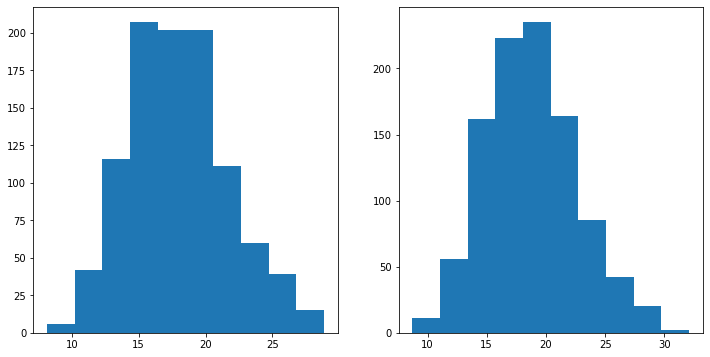

In [29]:
fig, ax = plt.subplots(1,2, figsize=(12,6))
ax[0].hist(linreg_mse)
ax[1].hist(xgboost_mse)

In [30]:
# Now mse for n_estimators in xgboost for MLS
N = 1000
linreg_mse = np.empty(N)
linreg_mse[:] = np.NaN
xgboost_mse = np.empty((5,N))
xgboost_mse[:] = np.NaN

# Named for MLS shot projections, but works for any league
mls_data = pd.read_csv("Shotlogs/MLS_shotlog.csv")
futures = mls_data[mls_data["Real_Shots"].isna()]
futures = futures[futures["Win_Odds"].notna()]
mls_data = mls_data[mls_data["Real_Shots"] > 0]

# Outliers w/ numbers
iqr = stats.iqr(mls_data["Real_Shots"])
outlier_cutoff_low = np.quantile(np.array(mls_data["Real_Shots"]),.25) - iqr*1.5
outlier_cutoff_high = np.quantile(np.array(mls_data["Real_Shots"]),.75) + iqr*1.5
num_outliers = sum(mls_data["Real_Shots"] > outlier_cutoff_high)
#print("num outliers:", num_outliers)
outlier_indices = []
for i in range(num_outliers):
    idx = mls_data["Real_Shots"].drop(outlier_indices).idxmax()
    outlier_indices.append(idx)
mls_data = mls_data.drop(outlier_indices).reset_index()

# Set X and y matrices for linear regression
X = np.array(mls_data[["Win_Odds", "FiveThirtyEight_Odds",
                       "Odds_GF", "OddsShark_GF",
                       "Opp_CS_Odds_INV", "Opp_Odds_INV", "Opp_FiveThirtyEight_Odds_INV"]])
y = np.array(mls_data["Real_Shots"])

for i in range(N):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

    linear_regression = LinearRegression(normalize=True)
    linear_regression.fit(X_train, y_train)
    y_pred = linear_regression.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    linreg_mse[i] = mse
    
    for n_est in [0, 1, 2, 3, 4]:
        params = {'n_estimators': (n_est*20)+20,
                  'max_depth': 4,
                  'min_samples_split': 5,
                  'learning_rate': 0.01,
                  'loss': 'ls'}
        reg = ensemble.GradientBoostingRegressor(**params)
        reg.fit(X_train, y_train)
        mse = mean_squared_error(y_test, reg.predict(X_test))
        xgboost_mse[n_est, i] = mse
    
    if ((i % 10) == 0):
        print(i)


0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990


In [31]:
print(linreg_mse.mean())
print(xgboost_mse[0,].mean())
print(xgboost_mse[1,].mean())
print(xgboost_mse[2,].mean())
print(xgboost_mse[3,].mean())
print(xgboost_mse[4,].mean())

18.07716237668804
19.816792100302465
19.272781137093343
18.9594809422206
18.791339675234322
18.7104341482595


In [32]:
# WARNING - THIS TAKES QUITE A WHILE TO RUN
# Now mse for n_estimators in xgboost for Premier League
N = 1000

linreg_mse = np.empty((6,N)); linreg_mse[:] = np.NaN
xgboost_mse = np.empty((6,N)); xgboost_mse[:] = np.NaN

leagues = ["MLS", "PremierLeague", "Bundesliga", "Ligue1", "SerieA", "LaLiga"]  # MLS, PremierLeague, Bundesliga, LaLiga, Ligue1, SerieA

lg_ctr = 0
for league in leagues:
    filename = "Shotlogs/" + league + "_shotlog.csv"
    
    # Named for MLS shot projections, but works for any league
    mls_data = pd.read_csv(filename)
    futures = mls_data[mls_data["Real_Shots"].isna()]
    futures = futures[futures["Win_Odds"].notna()]
    mls_data = mls_data[mls_data["Real_Shots"] > 0]

    # Outliers w/ numbers
    iqr = stats.iqr(mls_data["Real_Shots"])
    outlier_cutoff_low = np.quantile(np.array(mls_data["Real_Shots"]),.25) - iqr*1.5
    outlier_cutoff_high = np.quantile(np.array(mls_data["Real_Shots"]),.75) + iqr*1.5
    num_outliers = sum(mls_data["Real_Shots"] > outlier_cutoff_high)
    #print("num outliers:", num_outliers)
    outlier_indices = []
    for i in range(num_outliers):
        idx = mls_data["Real_Shots"].drop(outlier_indices).idxmax()
        outlier_indices.append(idx)
    mls_data = mls_data.drop(outlier_indices).reset_index()

    # Set X and y matrices for linear regression
    X = np.array(mls_data[["Win_Odds", "FiveThirtyEight_Odds",
                           "Odds_GF", "OddsShark_GF",
                           "Opp_CS_Odds_INV", "Opp_Odds_INV", "Opp_FiveThirtyEight_Odds_INV"]])
    y = np.array(mls_data["Real_Shots"])

    for i in range(N):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

        linear_regression = LinearRegression(normalize=True)
        linear_regression.fit(X_train, y_train)
        y_pred = linear_regression.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        linreg_mse[lg_ctr, i] = mse

        params = {'n_estimators': 75,
                  'max_depth': 4,
                  'min_samples_split': 5,
                  'learning_rate': 0.01,
                  'loss': 'ls'}
        reg = ensemble.GradientBoostingRegressor(**params)
        reg.fit(X_train, y_train)
        mse = mean_squared_error(y_test, reg.predict(X_test))
        xgboost_mse[lg_ctr, i] = mse

        if ((i % 10) == 0):
            print(league, i)
    lg_ctr+=1
    



MLS 0
MLS 10
MLS 20
MLS 30
MLS 40
MLS 50
MLS 60
MLS 70
MLS 80
MLS 90
MLS 100
MLS 110
MLS 120
MLS 130
MLS 140
MLS 150
MLS 160
MLS 170
MLS 180
MLS 190
MLS 200
MLS 210
MLS 220
MLS 230
MLS 240
MLS 250
MLS 260
MLS 270
MLS 280
MLS 290
MLS 300
MLS 310
MLS 320
MLS 330
MLS 340
MLS 350
MLS 360
MLS 370
MLS 380
MLS 390
MLS 400
MLS 410
MLS 420
MLS 430
MLS 440
MLS 450
MLS 460
MLS 470
MLS 480
MLS 490
MLS 500
MLS 510
MLS 520
MLS 530
MLS 540
MLS 550
MLS 560
MLS 570
MLS 580
MLS 590
MLS 600
MLS 610
MLS 620
MLS 630
MLS 640
MLS 650
MLS 660
MLS 670
MLS 680
MLS 690
MLS 700
MLS 710
MLS 720
MLS 730
MLS 740
MLS 750
MLS 760
MLS 770
MLS 780
MLS 790
MLS 800
MLS 810
MLS 820
MLS 830
MLS 840
MLS 850
MLS 860
MLS 870
MLS 880
MLS 890
MLS 900
MLS 910
MLS 920
MLS 930
MLS 940
MLS 950
MLS 960
MLS 970
MLS 980
MLS 990
PremierLeague 0
PremierLeague 10
PremierLeague 20
PremierLeague 30
PremierLeague 40
PremierLeague 50
PremierLeague 60
PremierLeague 70
PremierLeague 80
PremierLeague 90
PremierLeague 100
PremierLeague 110
Premie

In [33]:
leagues = ["MLS", "PremierLeague", "Bundesliga", "Ligue1", "SerieA", "LaLiga"]  # MLS, PremierLeague, Bundesliga, LaLiga, Ligue1, SerieA
for i in range(6):
    print(leagues[i])
    print("Lin Reg MSE: {:.4f}".format(linreg_mse[i,].mean()))
    print("XGBoost MSE: {:.4f}".format(xgboost_mse[i,].mean()))
    print("\n")

MLS
Lin Reg MSE: 18.2696
XGBoost MSE: 19.0340


PremierLeague
Lin Reg MSE: 22.1258
XGBoost MSE: 22.2999


Bundesliga
Lin Reg MSE: 16.9098
XGBoost MSE: 19.0082


Ligue1
Lin Reg MSE: 26.6530
XGBoost MSE: 23.4822


SerieA
Lin Reg MSE: 25.2324
XGBoost MSE: 29.4185


LaLiga
Lin Reg MSE: 13.3255
XGBoost MSE: 14.4622




### Looks like XGBoost does not perform much better than a normal linear regression for shots and shots on target 

### The next step is to create a goal projection model based off of poisson distribution
####   Inspired from this: https://www.americansocceranalysis.com/home/2020/11/15/explaining-our-2020-mls-playoffs-projections